# Graphs tutorial

We use the [`networkx`][networkx] library for dealing with graphs.

[networkx]: https://networkx.github.io

In [294]:
import networkx as nx

Another tutorial is available [here](https://networkx.github.io/documentation/stable/tutorial.html).


# Adding nodes and edges

Use the class `MultiDiGraph` to create a directed graph with multiple edges and self-loops.

In [295]:
G = nx.MultiDiGraph()

Add nodes using `add_node`:

In [296]:
G.add_node('node1')
G.add_node('node2')
G.add_node('node3')


Check that a node is in the graph:

In [297]:
assert 'node1' in G

Get all nodes:

In [298]:
list(G.nodes())

['node1', 'node3', 'node2']

Add some edges:

In [299]:
G.add_edge('node1', 'node2');

Nodes get automatically added:

In [300]:
G.add_edge('node2', 'another1');
G.add_edge('another1', 'another2');

List edges:

In [301]:
list(G.edges())

[('node1', 'node2'), ('node2', 'another1'), ('another1', 'another2')]

In [302]:
for a,b in G.edges():
    print('edge from %s to %s' % (a, b))

edge from node1 to node2
edge from node2 to another1
edge from another1 to another2


## Drawing graphs

There are some minimal plotting capabilities.

In [303]:
def draw_graph(G0, pos=None):
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    nx.draw(G0,pos,labels={node:node for node in G0.nodes()})
    def edge_label(a, b):
        datas = G0.get_edge_data(a, b)
        s = '%d edge%s' % (len(datas), 's' if len(datas)>=2 else '')
        for k, v in datas.items():
            if v:
                if 'label' in v:
                    s += '\n %s' % v['label']
                else:
                    s += '\n %s' %v
        return s
    edge_labels = dict([ ((a,b), edge_label(a,b)) for a,b in G0.edges()])
    nx.draw_networkx_edge_labels(G0,pos,edge_labels=edge_labels,font_color='red')
    plt.axis('off')
    plt.show()

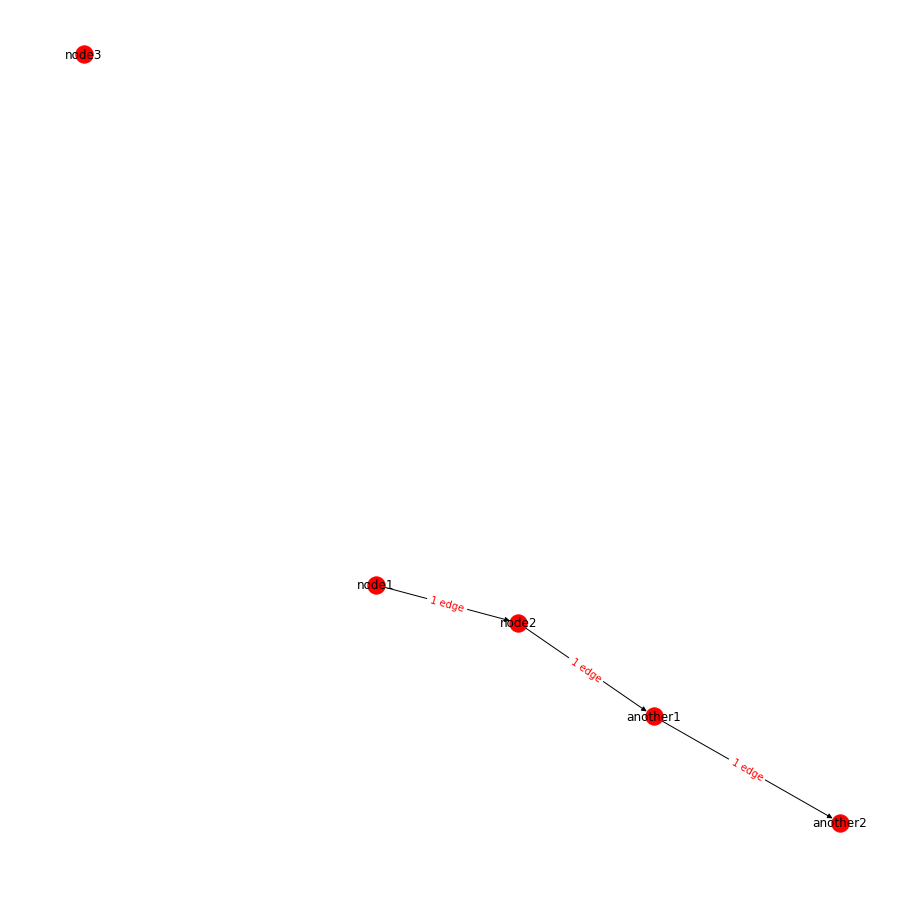

In [304]:
draw_graph(G)

## Multiple edges

You can add a second edge between the nodes:

In [305]:
G.add_edge('node1', 'node2');

Notice now how there are two copies of the same edge:

In [306]:
list(G.edges())

[('node1', 'node2'),
 ('node1', 'node2'),
 ('node2', 'another1'),
 ('another1', 'another2')]

Multiple edges in the graph:

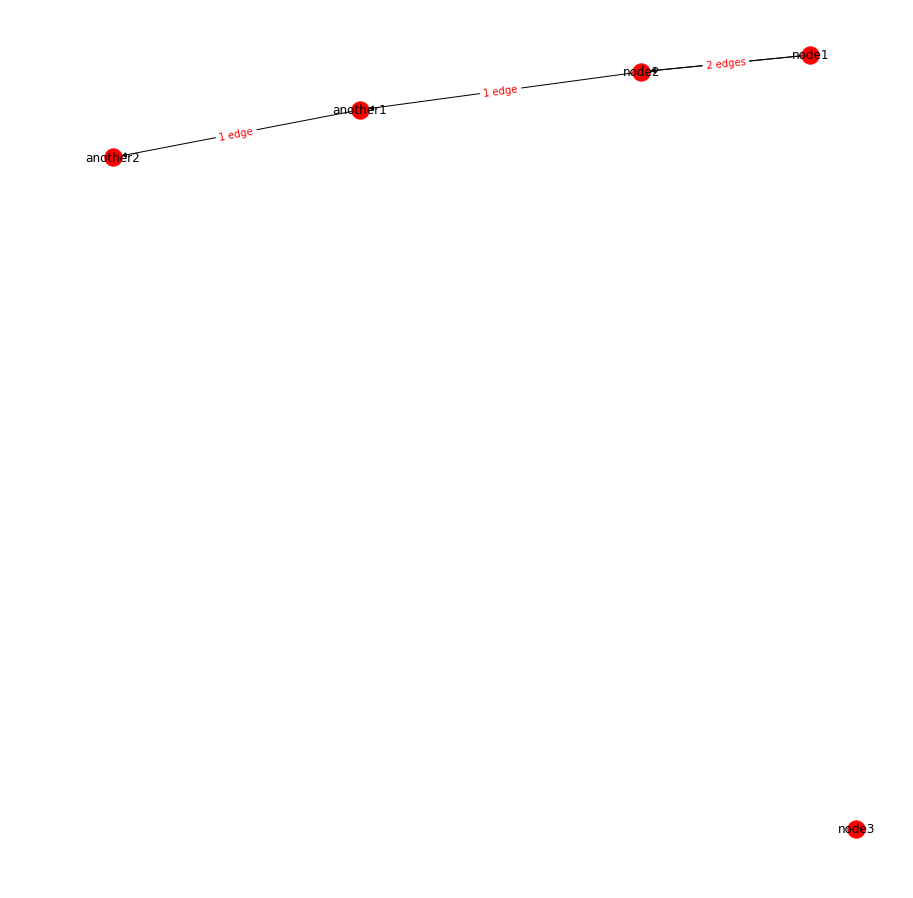

In [307]:
draw_graph(G)

## Attaching data to edges

You can use the optional parameters of the `add_edge` method to attach some pieces of data.

For example we add two more edges between `node1` and `node4` with property `prop` set to 12 and 15.

In [308]:
G.add_edge('node1', 'node4',  prop=12);
G.add_edge('node1', 'node4',   prop=15);

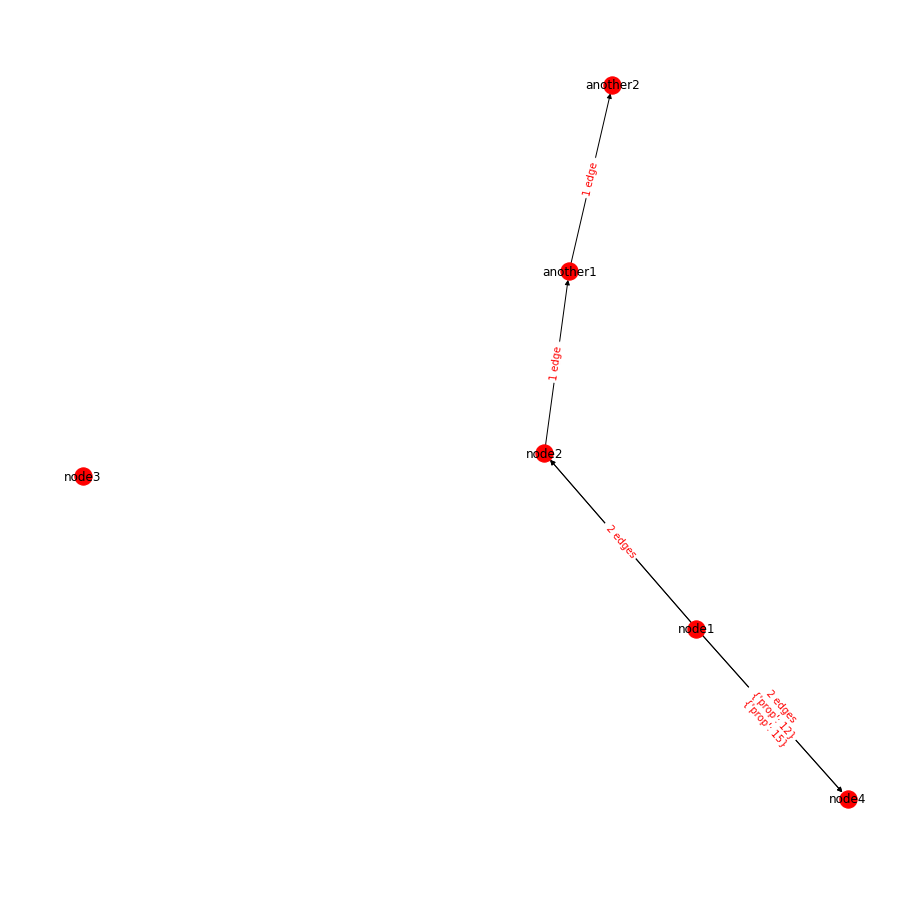

In [309]:
draw_graph(G)

Using the function `get_edge_data` we can get the data attached to the edge.
The function returns a dictionary 'edge-label -> properties', where `edge-label` is just an integer.

In [310]:
G.get_edge_data('node1', 'node4')

{0: {'prop': 12}, 1: {'prop': 15}}

In [311]:
for id_edge, edge_data in G.get_edge_data('node1', 'node4').items():
    print('edge %s: attribute  prop = %s' % (id_edge, edge_data['prop']))

edge 0: attribute  prop = 12
edge 1: attribute  prop = 15


## Querying the graph

Concepts:

- neighbors
- predecessors
- ancestors (transitive closure of predecessors)
- successors
- descendants (transitive closure of successors)

In [312]:
list(G.neighbors('node2'))


['another1']

In [313]:
list(G.predecessors('node2'))

['node1']

In [314]:
list(nx.ancestors(G, 'node2'))

['node1']

In [315]:
list(nx.descendants(G, 'node2'))

['another2', 'another1']

In [316]:
list(G.successors('node2'))

['another1']

## Cycles

Use the function `nx.simple_cycles` to get the cycles in the graph:

In [317]:
list(nx.simple_cycles(G))

[]

Let's create a more interesting graph:

In [318]:
G2 = nx.MultiDiGraph()
edges = [
    ('A','B'),
    ('B', 'C'),
    ('C', 'D'),
    ('D', 'E'),
    ('E', 'F'),
    ('F', 'A'),
    ('A', 'G'),
    ('G', 'H'),
    ('H', 'A')]
G2.add_edges_from(edges);

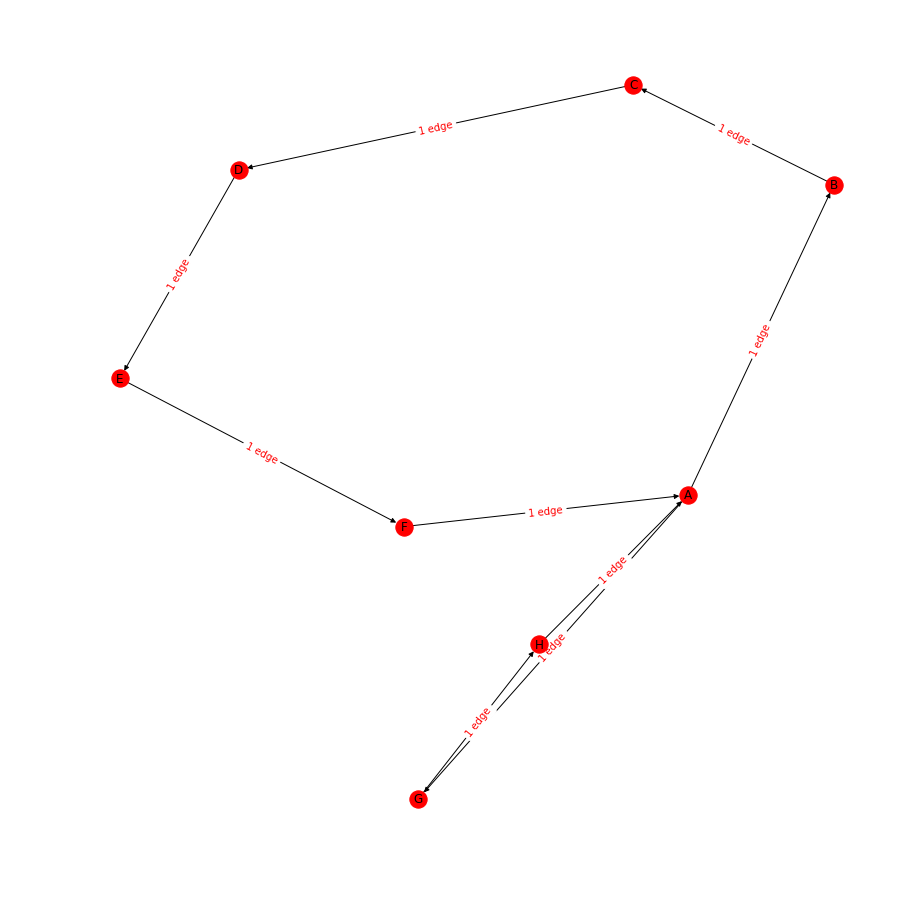

In [319]:
draw_graph(G2)

The function returns a list of lists:

In [320]:
list(nx.simple_cycles(G2))

[['A', 'G', 'H'], ['A', 'B', 'C', 'D', 'E', 'F']]

## Paths

Use `has_path` to check that two nodes are connected:

In [321]:
nx.has_path(G2, 'A', 'C')

True

In [322]:
nx.has_path(G2, 'C', 'A')

True

But what are these paths? Use `nx.shortest_path` to find out:

In [323]:
nx.shortest_path(G2, 'A', 'C')

['A', 'B', 'C']

In [324]:
nx.shortest_path(G2, 'C', 'A')

['C', 'D', 'E', 'F', 'A']

## Attaching data to nodes

Use kwargs of `add_node` to add attributes to nodes:

In [325]:
M = nx.DiGraph()
M.add_node('a', q=2)

Get it back using this syntax: 

In [326]:
M.nodes['a']

{'q': 2}

## Example: pose network

We create a *pose network*: a graph where each node represents a pose
and each edge is a measurement.

Let's create a grid-like network:

In [327]:
H, W = 4, 4

In [328]:
import itertools
import geometry as geo
M = nx.MultiDiGraph()
for i, j in itertools.product(range(H), range(W)):
    node_name = (i, j)
    q = geo.SE2_from_translation_angle((i, j), 0)
    M.add_node(node_name, q=q)

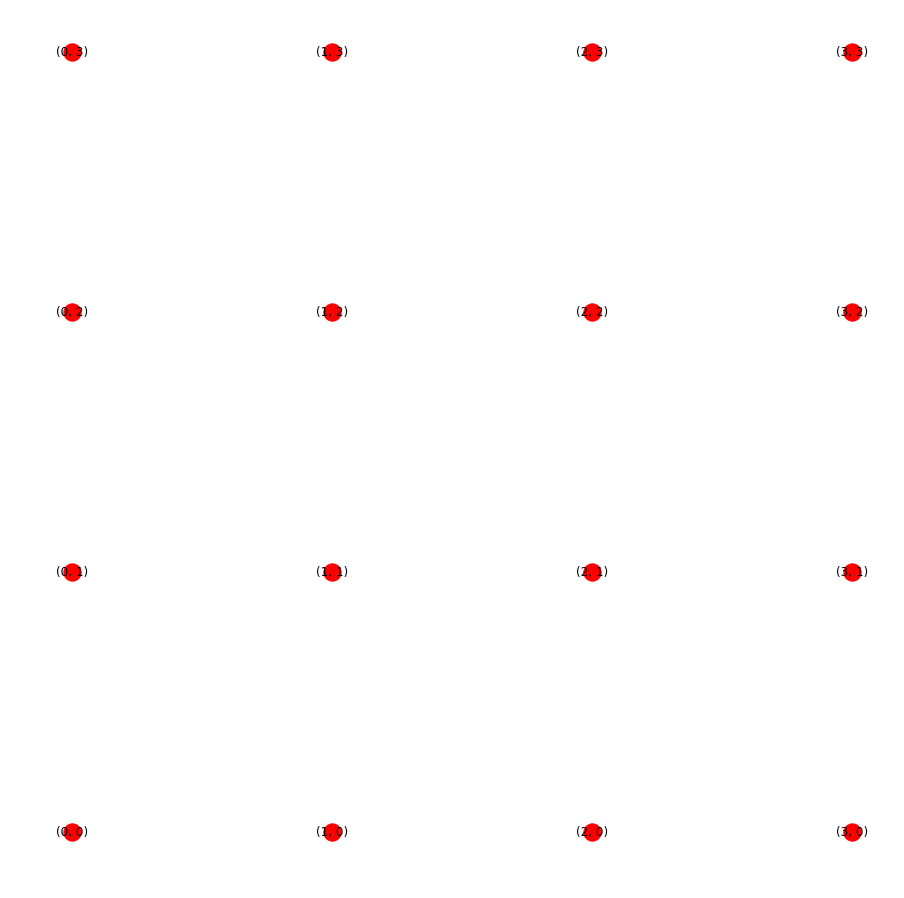

In [329]:
# let's plot them where they are supposed to go
def position_for_node(node):
    q = M.nodes[node]['q']
    t, _ = geo.translation_angle_from_SE2(q)
    return t
pos = dict([ (node, position_for_node(node)) for node in M])

draw_graph(M, pos=pos)

Now let's create the network connections:

In [330]:
for i, j in itertools.product(range(H), range(W)):
    # connect to neighbors
    for d in [(-1,0),(+1, 0),(0, +1), (0,-1)]:
        i2, j2 = i+d[0], j+d[1]
        # if neighbor exists
        if (i2,j2) in M:
            q1 = M.nodes[(i,j)]['q']
            q2 = M.nodes[(i2,j2)]['q']
            relative_pose = geo.SE2.multiply(geo.SE2.inverse(q1), q2)
            label = geo.SE2.friendly(relative_pose)
            M.add_edge( (i,j), (i2,j2), label=label, relative_pose=relative_pose)
            

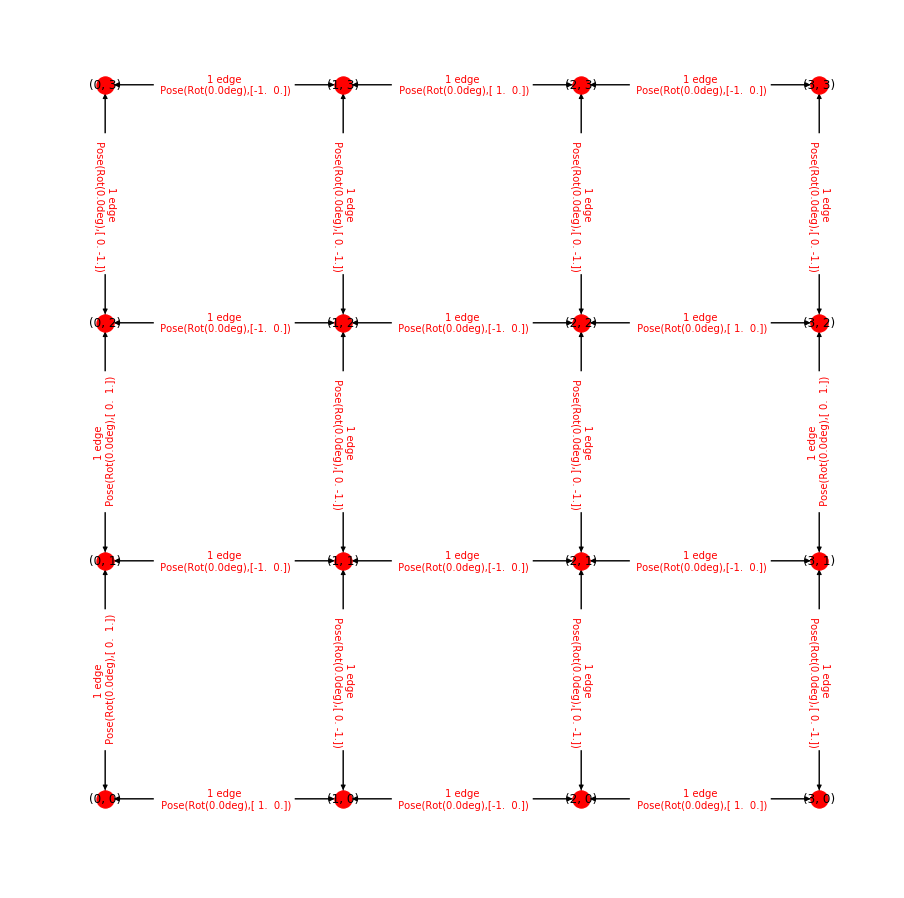

In [331]:
draw_graph(M, pos=pos)

Now let's find the relative position between two nodes using the graph functions. 


In [332]:
node1, node2 = (1,3), (2,1)

In [333]:
path = nx.shortest_path(M, node1, node2)
print(path)

[(1, 3), (1, 2), (1, 1), (2, 1)]


Get the edges from this sequence of nodes:

In [334]:
edges = zip(path[1:],path[:-1]) 
print(edges)

[((1, 2), (1, 3)), ((1, 1), (1, 2)), ((2, 1), (1, 1))]


We can recover the relative pose using `get_edge_data`:

In [335]:
for a, b in edges:
    R = M.get_edge_data(a, b)[0]['relative_pose']
    print('edge %s to %s: relative pose: %s' % (a, b, geo.SE2.friendly(R)))

edge (1, 2) to (1, 3): relative pose: Pose(Rot(0.0deg),[ 0.  1.])
edge (1, 1) to (1, 2): relative pose: Pose(Rot(0.0deg),[ 0.  1.])
edge (2, 1) to (1, 1): relative pose: Pose(Rot(0.0deg),[-1.  0.])


In [336]:
def sum_pose_along_edges(G, edges):
    S = geo.SE2.identity()
    for a, b in edges:
        R = G.get_edge_data(a, b)[0]['relative_pose']
        S = geo.SE2.multiply(S, R)
    return S

In [337]:
S = sum_pose_along_edges(M, edges)
print(geo.SE2.friendly(S))

Pose(Rot(0.0deg),[-1.  2.])
